In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import h5py
from GWForge.population.redshift import Redshift
import bilby
import numpy as np
import pylab as plt
import os
from glob import glob
import seaborn as sns
import pandas as pd
import dill
from tqdm import tqdm
from scipy.stats import ncx2
from pycbc.waveform import get_fd_waveform
import sys
sys.path.append('../../')
from utils import save_results_to_h5

In [2]:
MDhigh_params = {'gamma':2.7, 'kappa':5.6, 'z_peak':2.53}
MDlow_params = {'gamma':2.7, 'kappa':5.6, 'z_peak':1.54}
MD_params = {'gamma':2.7, 'kappa':5.6, 'z_peak':1.9}

In [3]:
pop_num = 2

if pop_num == 4:
    pop_params = MDhigh_params
    MDmodel = 'MDhigh'
    z_str = f'z_{MDmodel}_zp_{pop_params["z_peak"]}'
elif pop_num == 5:
    pop_params = MDlow_params
    MDmodel = 'MDlow'
    z_str = f'z_{MDmodel}_zp_{pop_params["z_peak"]}'
else:
    pop_params = MD_params
    z_str = 'z_MD'

netw = 'LHI_Asharp'
#netw = 'CE4020ET123_CoBA10'

if 'Asharp' in netw:
    identifier = f'prec_fref_10_{z_str}'
elif 'CE4020ET123' in netw:
    if pop_num == 2:
        identifier = f'prec_{z_str}'
    else:
        identifier = f'prec_fref_5_{z_str}'
project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
study_label = f'{netw}_SNR_{pop_num}_pop_PLP_spin_{identifier}_zmax_10_lmrd_22_corrected_td'

In [4]:
#z_max = 6
z_max = 11
print(pop_params)
gwf_z = Redshift(redshift_model='MadauDickinson', 
                 local_merger_rate_density=22, 
                 maximum_redshift=z_max, 
                 gps_start_time=0, 
                 parameters=pop_params)
gwf_z_prob = gwf_z.coalescence_rate()

{'gamma': 2.7, 'kappa': 5.6, 'z_peak': 1.9}


Output()

In [8]:
z_grid = np.arange(0, z_max, 0.001)
p_z = bilby.core.prior.Interped(z_grid, gwf_z_prob(z_grid))

## Check the probability function against input population

/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/input_population/BBH/2_pop_PLP_spin_prec_fref_10_z_MD_zmax_10_lmrd_22_365_days_corrected_td.h5


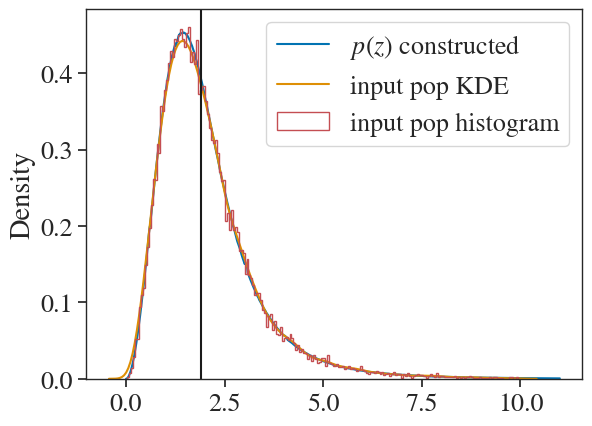

In [9]:
input_file = glob(os.path.join(project_dir, 'input_population', 'BBH', f'{pop_num}_pop*{identifier}*.h5'))[0]
print(input_file)
with h5py.File(input_file, 'r') as f:
#with h5py.File(glob(os.path.join(project_dir, 'input_population', 'BBH', '1_pop*.h5'))[0], 'r') as f:
    input_z = f['redshift'][:]
plt.plot(z_grid, p_z.probability_density(z_grid), label='$p(z)$ constructed')
sns.kdeplot(input_z, label='input pop KDE')
plt.hist(input_z, bins=200, histtype='step', density=True, label='input pop histogram', color='r');
plt.axvline(1.9, c='k')
plt.legend()

In [10]:
len(input_z)

31728

## Get SNRs, masses, and redshift

In [11]:
if 'Asharp' in netw:
    dets = ['L1', 'H1', 'I1']
    very_high_SNR_val = 1000
elif 'CE4020ET123' in netw:
    dets = ['C1', 'CE20', 'E1', 'E2', 'E3']
    very_high_SNR_val = 6500
injected_data = {'total':{}}
#select_params = ['distance','redshift', 'srcmass1', 'srcmass2', 'srcmtotal']
select_params = ['distance','redshift', 'srcmtotal']

weird_points = {'index':[], 'params':[]}
for det in dets + ['network']:
    select_params.append(f'SNR_{det}')
#    select_params.append(f'SNR_mf_{det}')
    select_params.append(f'SNR_mf_from_opt_{det}')
    
for param in tqdm(select_params):
    injected_data['total'][param] = []
    offset = 1200 # number of injection files already combined
    for i in list(range(1200)):
        file_name = os.path.join(project_dir, 'gwpopulation', 'BBH', 'injections', 
                                 'SNR_output_files_XPHM', 
                                 study_label.replace('_Asharp', ''), 
                                 f'{study_label.replace("_Asharp", "")}_part{i+offset}_SNR_data.h5')
        with h5py.File(file_name, 'r') as f:
            injected_data['total'][param].append(f['results'][param][:])
            if param == select_params[0]: #just need to run the code block once hence this if statement
                weird_idxs_in_file = np.where(f['results']['SNR_network'][()] > very_high_SNR_val)[0]
                if len(weird_idxs_in_file) != 0:
                    weird_points['index'].extend(list(weird_idxs_in_file+10000*i))
                    for idx in weird_idxs_in_file:
                        weird_points['params'].append({key:f['results'][key][idx] for key in f['results'].keys()})
    injected_data['total'][param] = np.concatenate(injected_data['total'][param])

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:08<00:00,  1.23it/s]


In [12]:
pd.DataFrame(injected_data['total'])[injected_data['total']['SNR_mf_from_opt_network']>very_high_SNR_val]

,distance,redshift,srcmtotal,SNR_L1,SNR_mf_from_opt_L1,SNR_H1,SNR_mf_from_opt_H1,SNR_I1,SNR_mf_from_opt_I1,SNR_network,SNR_mf_from_opt_network
4810335,9280.753230,1.288008,14.964394,1.892801e+17,1.892801e+17,2.801298e+17,2.801298e+17,3.219060e+17,3.219060e+17,4.668223e+17,4.668223e+17
5032261,4250.664356,0.682525,13.034474,1.051793e+12,1.051793e+12,9.037802e+11,9.037802e+11,1.557904e+12,1.557904e+12,2.085702e+12,2.085702e+12
7235256,20249.647996,2.435486,11.377610,2.511617e+03,2.513397e+03,2.365661e+03,2.366884e+03,1.732517e+03,1.731071e+03,3.860853e+03,3.862112e+03
7345355,8015.144300,1.143698,14.370145,9.552662e+23,9.552662e+23,1.686545e+24,1.686545e+24,8.381904e+23,8.381904e+23,2.111760e+24,2.111760e+24
10321188,5740.591654,0.872343,10.063887,7.788822e+10,7.788822e+10,1.349432e+11,1.349432e+11,6.296591e+10,6.296591e+10,1.680504e+11,1.680504e+11
11128866,5127.656870,0.795702,10.128391,3.275890e+04,3.275879e+04,3.699939e+04,3.700025e+04,1.229068e+04,1.229105e+04,5.092309e+04,5.092373e+04
11788378,9340.793400,1.294760,18.259783,3.765315e+11,3.765315e+11,3.043221e+11,3.043221e+11,5.874727e+11,5.874727e+11,7.612570e+11,7.612570e+11


In [13]:
np.all([weird_points['index'], pd.DataFrame(injected_data['total'])[injected_data['total']['SNR_mf_from_opt_network']>very_high_SNR_val].index])

True

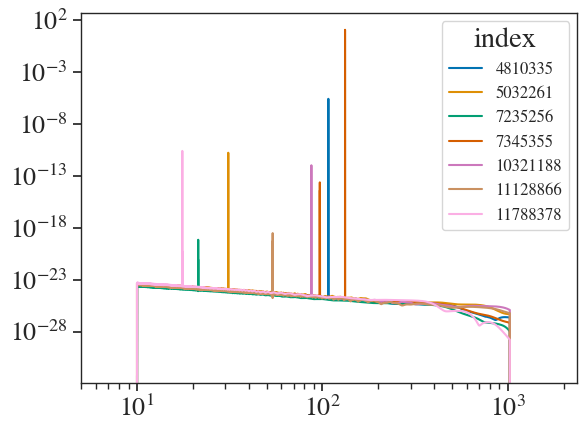

In [14]:
for idx, params in zip(weird_points['index'], weird_points['params']):
    params['approximant'] = 'IMRPhenomXPHM'
    hp, hc = get_fd_waveform(**params)
    plt.loglog(hp.sample_frequencies, abs(hp), label=idx)
    plt.xlim(5, )
    plt.legend(title='index', fontsize=12)

### Remove the weird data points

In [15]:
for key, arr in injected_data['total'].items():
    injected_data['total'][key] = np.delete(arr, weird_points['index'])

### Plot SNRs

In [16]:
injected_data['total'].keys()

dict_keys(['distance', 'redshift', 'srcmtotal', 'SNR_L1', 'SNR_mf_from_opt_L1', 'SNR_H1', 'SNR_mf_from_opt_H1', 'SNR_I1', 'SNR_mf_from_opt_I1', 'SNR_network', 'SNR_mf_from_opt_network'])

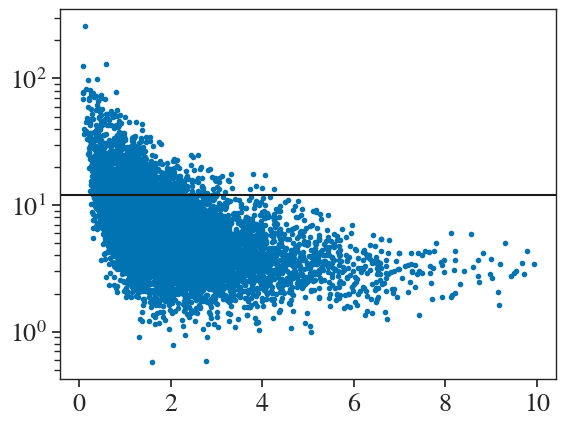

In [17]:
npoints = int(1e4)
plt.plot(injected_data['total']['redshift'][:npoints], 
         injected_data['total']['SNR_mf_from_opt_network'][:npoints], 
         '.')
plt.yscale('log')
#plt.axvline(12, color='k')
#plt.axhline(1, color='k')
plt.axhline(12, c='k')

In [18]:
len(injected_data['total']['redshift'])

11999993

## Save the total population before detected

In [19]:
study_label

'LHI_Asharp_SNR_2_pop_PLP_spin_prec_fref_10_z_MD_zmax_10_lmrd_22_corrected_td'

In [20]:
combined_h5_file = os.path.join(project_dir, 'gwpopulation', 'BBH', 'injections', 'combined_h5_files_select_params', 
                                f'{study_label}_12M_points_XPHM_total_batch2.h5')
combined_h5_file

'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/injections/combined_h5_files_select_params/LHI_Asharp_SNR_2_pop_PLP_spin_prec_fref_10_z_MD_zmax_10_lmrd_22_corrected_td_12M_points_XPHM_total_batch2.h5'

In [21]:
save_results_to_h5(injected_data, combined_h5_file)

## Get detected population for injections

In [17]:
def get_detected_SNRs(data_dict, ifo_threshold=5, network_threshold=12, 
                      method='network', return_detected_dict=False, 
                      snr_type='mf_from_opt'):
    if type(data_dict) == pd.core.frame.DataFrame:
        pass
    else:
        data_dict = pd.DataFrame(data_dict)
        
    if snr_type == 'opt':
        SNR_keys = [key for key in data_dict.keys() if 'SNR' in key and 'mf' not in key]
    elif snr_type == 'mf_from_opt':
        SNR_keys = [key for key in data_dict.keys() if 'SNR_mf_from_opt' in key]
    elif snr_type == 'mf':
        SNR_keys = [key for key in data_dict.keys() if 'SNR_mf' in key and 'from_opt' not in key]
    else:
        raise KeyError('Please choose snr_type from "opt" or "mf"')
    print(SNR_keys)
    detected_bool_dict = {}
    detected_dict = {}
    
    for key in SNR_keys:
        if snr_type == 'opt':
            dict_key = key.split('SNR_')[-1]
        elif snr_type == 'mf_from_opt':
            dict_key = key.split('SNR_mf_from_opt_')[-1]
        elif snr_type == 'mf':
            dict_key = key.split('SNR_mf_')[-1]
        
        if "network" in key:
            threshold = network_threshold
        else:
            threshold = ifo_threshold

        detected_bool_dict[dict_key] = data_dict[key] >= threshold
        detected_dict[dict_key] = data_dict[detected_bool_dict[dict_key]]

    if method=='all':
        detected_events_df = data_dict[np.all(tuple(detected_bool_dict.values()), axis=0) & detected_bool_dict['network']]
    elif method == 'two-detector':
        detector_keys = [key for key in detected_bool_dict.keys() if key != 'network']
        detection_sum = np.sum([detected_bool_dict[key] for key in detector_keys], axis=0)
        detected_events_df = data_dict[(detection_sum >= 2) & (detected_bool_dict['network'])]
    elif method=='network':
        detected_events_df = detected_dict['network']

    if return_detected_dict:
        return(detected_events_df, detected_dict)
    else:
        return(detected_events_df)

In [19]:
injected_data.keys()

dict_keys(['total'])

In [17]:
#injected_data['detected'] = get_detected_SNRs(injected_data['total'], method='two-detector', snr_type='opt')
#injected_data['detected_mf'] = get_detected_SNRs(injected_data['total'], method='two-detector', snr_type='mf')
injected_data['detected_mf_from_opt'] = get_detected_SNRs(injected_data['total'], 
                                                          method='two-detector', snr_type='mf_from_opt')

['SNR_mf_from_opt_L1', 'SNR_mf_from_opt_H1', 'SNR_mf_from_opt_I1', 'SNR_mf_from_opt_network']


In [18]:
#len(injected_data['detected']['redshift']), len(injected_data['detected_mf']['redshift']), len(injected_data['detected_mf_from_opt']['redshift'])
num_detected = len(injected_data['detected_mf_from_opt']['redshift'])
print('Detected =', num_detected, f"({num_detected*100/len(injected_data['total']['redshift']):.2f} %)")

Detected = 1654885 (13.79 %)


## Combine data from previous batch

In [19]:
from utils import load_results_from_h5
prev_file = os.path.join(project_dir, 'gwpopulation', 'BBH', 'injections', 'combined_h5_files_select_params', 
                         f'{study_label}_12M_points_XPHM.h5')
prev_data = load_results_from_h5(prev_file)

In [20]:
for key in injected_data['total'].keys():
    print(key, type(prev_data['total'][key]), type(injected_data['total'][key]))

distance <class 'numpy.ndarray'> <class 'numpy.ndarray'>
redshift <class 'numpy.ndarray'> <class 'numpy.ndarray'>
srcmtotal <class 'numpy.ndarray'> <class 'numpy.ndarray'>


KeyError: 'SNR_L1'

## Create gwpopulation injection prior for redshift

In [19]:
injected_data['detected_mf_from_opt']['p_z'] = p_z.probability_density(injected_data['detected_mf_from_opt']['redshift'])

Text(0.5, 0, '$z$')

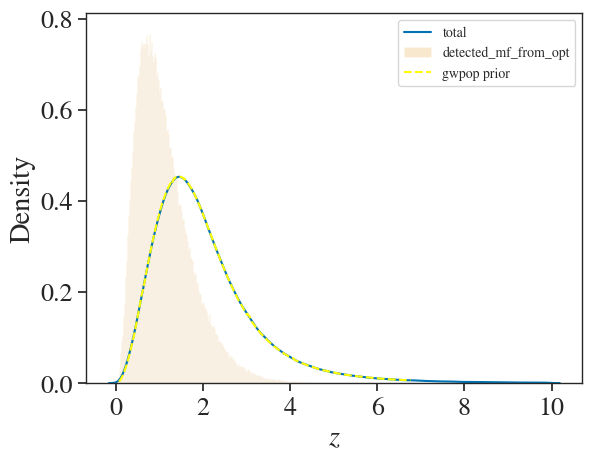

In [ ]:
npoints = int(1e6)
sns.kdeplot(injected_data['total']['redshift'][:npoints], label='total')
plt.hist(injected_data['detected_mf_from_opt']['redshift'][:npoints], label='detected_mf_from_opt', bins=1000, alpha=0.2, density=True)
sort_idx_mf = np.argsort(injected_data['detected_mf_from_opt']['redshift'][:npoints])
plt.plot(np.array(injected_data['detected_mf_from_opt']['redshift'][:npoints])[sort_idx_mf], 
         np.array(injected_data['detected_mf_from_opt']['p_z'][:npoints])[sort_idx_mf], label='gwpop prior', ls='--', c='yellow')
plt.legend(loc=1, fontsize=10)
plt.xlabel('$z$')

## Write to file

#### MF from opt SNR detected population

In [23]:
z_dict_write_mf_from_opt = {'redshift':np.array(injected_data['detected_mf_from_opt']['redshift']), 
                            'prior':np.array(injected_data['detected_mf_from_opt']['p_z']),
                            'total_generated':len(injected_data['total']['redshift'])}

In [24]:
z_dict_write_mf_from_opt

{'redshift': array([1.00002448, 0.83036667, 1.15565586, ..., 0.40397554, 2.30781895,
        1.20087956]),
 'prior': array([0.37514965, 0.30705593, 0.42047154, ..., 0.10145747, 0.29202364,
        0.4300392 ]),
 'total_generated': 11999993}

In [43]:
out_file = os.path.join(project_dir, 'gwpopulation', 'BBH', 'injections', f'{study_label}_detected_injs_mf_from_opt_SNR_12M_points_XPHM.pkl')
out_file

'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/injections/LHI_Asharp_SNR_2_pop_PLP_spin_prec_fref_10_z_MD_zmax_10_lmrd_22_corrected_td_detected_injs_mf_from_opt_SNR_12M_points_XPHM.pkl'

In [44]:
with open(out_file, 'wb') as f:
    dill.dump(z_dict_write_mf_from_opt, f)

In [45]:
study_label

'LHI_Asharp_SNR_2_pop_PLP_spin_prec_fref_10_z_MD_zmax_10_lmrd_22_corrected_td'

## Save the combined h5 file for select params

In [27]:
study_label

'LHI_Asharp_SNR_2_pop_PLP_spin_prec_fref_10_z_MD_zmax_10_lmrd_22_corrected_td'

In [28]:
combined_h5_file = os.path.join(project_dir, 'gwpopulation', 'BBH', 'injections', 'combined_h5_files_select_params', 
                                f'{study_label}_12M_points_XPHM_batch2.h5')
combined_h5_file

'/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/injections/combined_h5_files_select_params/LHI_Asharp_SNR_2_pop_PLP_spin_prec_fref_10_z_MD_zmax_10_lmrd_22_corrected_td_12M_points_XPHM_batch2.h5'

In [29]:
save_results_to_h5(injected_data, combined_h5_file)